<a href="https://colab.research.google.com/github/kthur/kthur/blob/master/%5BAI_Essential%5D_1028_3%EC%9D%BC%EC%B0%A8_%EC%8B%A4%EC%8A%B5_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install JAEN  -qU

In [ ]:
import JAEN
print(JAEN.__version__) # 버전확인

In [ ]:
# 필요 도구 import
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,
from JAEN.utils import train_and_evaluate, plot_training_results


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
# FashionMNIST 데이터 변환 (이미지를 텐서로 변환하고 [0, 1] 범위로 정규화)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# 학습 및 테스트 데이터셋 로드
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# CNN

## 05-001 2D 컨볼루션 출력 크기 계산 함수 구현

In [ ]:
def conv2d_output_size(input_size, kernel_size, stride=1, padding=0):
    height, width = input_size

    # Convolution 공식 적용
    out_height = (height + 2 * padding - kernel_size) // stride + 1
    out_width = (width + 2 * padding - kernel_size) // stride + 1

    return out_height, out_width

## 05-002 컨볼루션 출력 크기 계산

In [ ]:
# 입력 크기 (Height, Width), 커널 크기, 스트라이드, 패딩
output_size = conv2d_output_size((28, 28), 3, 1, 0)
print(f"Output feature map size: {output_size}")

Output feature map size: (26, 26)


## 05-003 패딩을 포함한 컨볼루션 출력 크기 계산

In [ ]:
# 입력 크기 (Height, Width), 커널 크기, 스트라이드, 패딩
output_size = conv2d_output_size((28, 28), 3, 1, 1)
print(f"Output feature map size: {output_size}")

Output feature map size: (28, 28)


## 05-004 스트라이드를 포함한 컨볼루션 출력 크기 계산

In [ ]:
# 입력 크기 (Height, Width), 커널 크기, 스트라이드, 패딩
output_size = conv2d_output_size((28, 28), 3, 2, 0)
print(f"Output feature map size: {output_size}")

Output feature map size: (13, 13)


## 05-005 스트라이드 및 패딩을 포함한 컨볼루션 출력 크기 계산

In [ ]:
# 입력 크기 (Height, Width), 커널 크기, 스트라이드, 패딩
output_size = conv2d_output_size((28, 28), 3, 2, 1)
print(f"Output feature map size: {output_size}")

Output feature map size: (14, 14)


## 05-006 CNN 모델 클래스 정의

In [ ]:
# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 첫 번째 컨볼루션 레이어
        # 입력 채널: 1 (흑백 이미지), 출력 채널: 16, 커널 크기: 3x3, 패딩: 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)

        # 두 번째 컨볼루션 레이어
        # 입력 채널: 16, 출력 채널: 32, 커널 크기: 3x3, 패딩: 1
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # MaxPool 레이어 (다운샘플링)
        # 커널 크기: 2x2, 스트라이드: 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 첫 번째 완전 연결 (Fully Connected) 레이어
        # 입력 크기: 32 * 7 * 7 (Conv2d 출력을 펼친 크기), 출력 크기: 128
        self.fc1 = nn.Linear(32 * 7 * 7, 128)

        # 두 번째 완전 연결 레이어
        # 입력 크기: 128, 출력 크기: 10 (클래스 개수)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # 입력 데이터 크기: (batch_size, 1, 28, 28)

        # 첫 번째 Conv + ReLU + MaxPool
        # Conv 후 크기: (batch_size, 16, 28, 28)
        # MaxPool 후 크기: (batch_size, 16, 14, 14)
        x = self.pool(torch.relu(self.conv1(x)))

        # 두 번째 Conv + ReLU + MaxPool
        # Conv 후 크기: (batch_size, 32, 14, 14)
        # MaxPool 후 크기: (batch_size, 32, 7, 7)
        x = self.pool(torch.relu(self.conv2(x)))

        # Flatten: Conv 출력을 1차원 벡터로 펼침
        # Flatten 후 크기: (batch_size, 32 * 7 * 7)
        x = x.reshape(-1, 32 * 7 * 7)

        # 첫 번째 Fully Connected + ReLU
        # 출력 크기: (batch_size, 128)
        x = torch.relu(self.fc1(x))

        # 두 번째 Fully Connected (출력층)
        # 출력 크기: (batch_size, 10)
        x = self.fc2(x)

        return x

# 모델 요약 출력
model = CNN().to(device)
summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─MaxPool2d: 1-2                         [64, 16, 14, 14]          --
├─Conv2d: 1-3                            [64, 32, 14, 14]          4,640
├─MaxPool2d: 1-4                         [64, 32, 7, 7]            --
├─Linear: 1-5                            [64, 128]                 200,832
├─Linear: 1-6                            [64, 10]                  1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
Total mult-adds (M): 79.17
Input size (MB): 0.20
Forward/backward pass size (MB): 9.70
Params size (MB): 0.83
Estimated Total Size (MB): 10.73

## 05-007 손실 함수 및 옵티마이저 설정과 학습 수행

In [ ]:
# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류를 위한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device=device
)

Epoch [1]
Train Loss: 0.7745, Train Accuracy: 74.05%
Test Loss: 0.5282, Test Accuracy: 80.30%
Epoch [2]
Train Loss: 0.4675, Train Accuracy: 83.16%
Test Loss: 0.4633, Test Accuracy: 83.39%
Epoch [3]
Train Loss: 0.4130, Train Accuracy: 85.36%
Test Loss: 0.4145, Test Accuracy: 85.26%
Epoch [4]
Train Loss: 0.3823, Train Accuracy: 86.56%
Test Loss: 0.3905, Test Accuracy: 86.20%
Epoch [5]
Train Loss: 0.3601, Train Accuracy: 87.30%
Test Loss: 0.3645, Test Accuracy: 86.86%
Epoch [6]
Train Loss: 0.3443, Train Accuracy: 87.76%
Test Loss: 0.3511, Test Accuracy: 87.28%
Epoch [7]
Train Loss: 0.3281, Train Accuracy: 88.48%
Test Loss: 0.3459, Test Accuracy: 87.38%
Epoch [8]
Train Loss: 0.3158, Train Accuracy: 88.80%
Test Loss: 0.3367, Test Accuracy: 87.89%
Epoch [9]
Train Loss: 0.3041, Train Accuracy: 89.14%
Test Loss: 0.3247, Test Accuracy: 88.25%
Epoch [10]
Train Loss: 0.2938, Train Accuracy: 89.49%
Test Loss: 0.3233, Test Accuracy: 88.19%


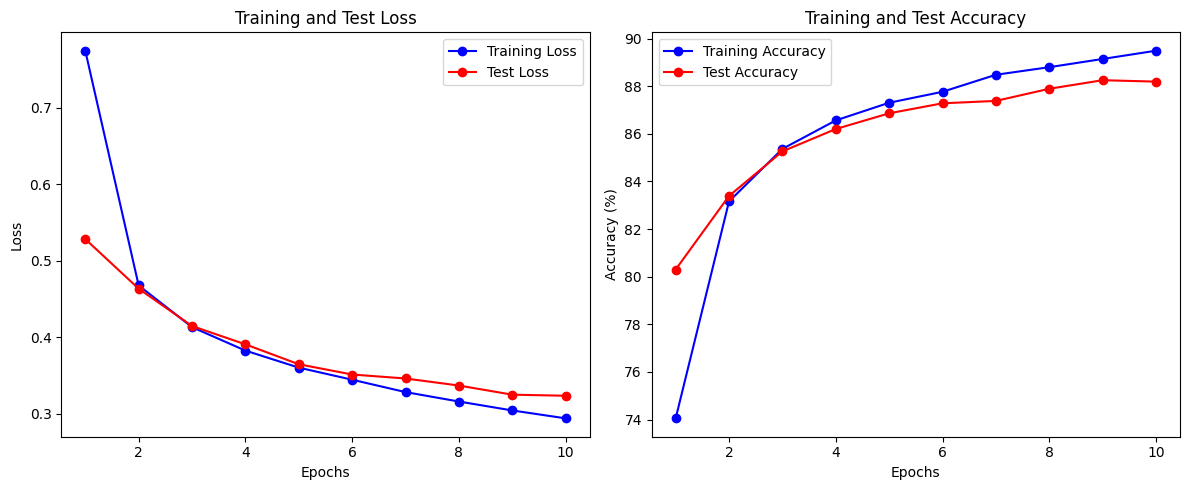

In [ ]:
# 결과 시각화
plot_training_results(train_losses, train_accuracies, test_losses, test_accuracies)

## 05-008 JAEN 패키지에서 CNN 모델 불러오기

In [ ]:
# JAEN 패키지에서 CNN 모델 가져오기
from JAEN.models import CNNModel

# CNN 모델 불러오기 (pretrained=True)
model = CNNModel(pretrained=True)

# 모델 정보 확인
summary(model, (64, 1, 28, 28))

Pretrained weights loaded successfully on cuda.


/usr/local/lib/python3.10/dist-packages/JAEN/models.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location=device))


Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [64, 10]                  --
├─Sequential: 1-1                        [64, 32, 7, 7]            --
│    └─Conv2d: 2-1                       [64, 16, 28, 28]          160
│    └─ReLU: 2-2                         [64, 16, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 16, 28, 28]          2,320
│    └─ReLU: 2-4                         [64, 16, 28, 28]          --
│    └─MaxPool2d: 2-5                    [64, 16, 14, 14]          --
│    └─Conv2d: 2-6                       [64, 32, 14, 14]          4,640
│    └─ReLU: 2-7                         [64, 32, 14, 14]          --
│    └─Conv2d: 2-8                       [64, 32, 14, 14]          9,248
│    └─ReLU: 2-9                         [64, 32, 14, 14]          --
│    └─MaxPool2d: 2-10                   [64, 32, 7, 7]            --
├─Sequential: 1-2                        [64, 10]                  --
│    

## 05-009 기존 Conv Block 동결

In [ ]:
# 기존 Conv Block 동결
for param in model.conv_layers.parameters():
    param.requires_grad = False

## 05-010 새로운 Fully Connected Block 설정

In [ ]:
# 새로운 Fully Connected Block 설정
model.fc_layers = nn.Sequential(
    nn.Linear(32 * 7 * 7, 64),  # 첫 번째 은닉층
    nn.ReLU(),
    nn.Dropout(p=0.5),           # 드롭아웃 추가
    nn.Linear(64, 10)           # 출력층 (활성화 함수 없음)
)

# 디바이스 설정 (GPU 또는 CPU)
model = model.to(device)
summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [64, 10]                  --
├─Sequential: 1-1                        [64, 32, 7, 7]            --
│    └─Conv2d: 2-1                       [64, 16, 28, 28]          (160)
│    └─ReLU: 2-2                         [64, 16, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 16, 28, 28]          (2,320)
│    └─ReLU: 2-4                         [64, 16, 28, 28]          --
│    └─MaxPool2d: 2-5                    [64, 16, 14, 14]          --
│    └─Conv2d: 2-6                       [64, 32, 14, 14]          (4,640)
│    └─ReLU: 2-7                         [64, 32, 14, 14]          --
│    └─Conv2d: 2-8                       [64, 32, 14, 14]          (9,248)
│    └─ReLU: 2-9                         [64, 32, 14, 14]          --
│    └─MaxPool2d: 2-10                   [64, 32, 7, 7]            --
├─Sequential: 1-2                        [64, 10]                  

## 05-011 손실 함수 및 최적화 도구 정의와 학습 수행

In [ ]:
# 손실 함수와 최적화 도구 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device=device
)

Epoch [1]
Train Loss: 0.8681, Train Accuracy: 72.22%
Test Loss: 0.5214, Test Accuracy: 82.51%
Epoch [2]
Train Loss: 0.5503, Train Accuracy: 81.59%
Test Loss: 0.4482, Test Accuracy: 84.71%
Epoch [3]
Train Loss: 0.4811, Train Accuracy: 83.86%
Test Loss: 0.4162, Test Accuracy: 85.85%
Epoch [4]
Train Loss: 0.4428, Train Accuracy: 84.97%
Test Loss: 0.3964, Test Accuracy: 86.17%
Epoch [5]
Train Loss: 0.4205, Train Accuracy: 85.85%
Test Loss: 0.3827, Test Accuracy: 86.76%
Epoch [6]
Train Loss: 0.4010, Train Accuracy: 86.20%
Test Loss: 0.3691, Test Accuracy: 87.07%
Epoch [7]
Train Loss: 0.3857, Train Accuracy: 86.82%
Test Loss: 0.3597, Test Accuracy: 87.53%
Epoch [8]
Train Loss: 0.3726, Train Accuracy: 87.22%
Test Loss: 0.3557, Test Accuracy: 87.44%
Epoch [9]
Train Loss: 0.3629, Train Accuracy: 87.42%
Test Loss: 0.3495, Test Accuracy: 87.73%
Epoch [10]
Train Loss: 0.3536, Train Accuracy: 87.93%
Test Loss: 0.3451, Test Accuracy: 87.78%


## 05-012 마지막 두 Conv 레이어만 학습하도록 설정

In [ ]:
# 마지막 두 Conv 레이어만 학습하도록 설정
for name, p in model.conv_layers.named_parameters():
    if name in ['5.weight', '5.bias', '7.weight', '7.bias']:
        p.requires_grad = True

In [ ]:
summary(model, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [64, 10]                  --
├─Sequential: 1-1                        [64, 32, 7, 7]            --
│    └─Conv2d: 2-1                       [64, 16, 28, 28]          (160)
│    └─ReLU: 2-2                         [64, 16, 28, 28]          --
│    └─Conv2d: 2-3                       [64, 16, 28, 28]          (2,320)
│    └─ReLU: 2-4                         [64, 16, 28, 28]          --
│    └─MaxPool2d: 2-5                    [64, 16, 14, 14]          --
│    └─Conv2d: 2-6                       [64, 32, 14, 14]          4,640
│    └─ReLU: 2-7                         [64, 32, 14, 14]          --
│    └─Conv2d: 2-8                       [64, 32, 14, 14]          9,248
│    └─ReLU: 2-9                         [64, 32, 14, 14]          --
│    └─MaxPool2d: 2-10                   [64, 32, 7, 7]            --
├─Sequential: 1-2                        [64, 10]                  --
│

## 05-013 손실 함수 및 최적화 도구 정의와 학습 수행

In [ ]:
# 손실 함수와 최적화 도구 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device=device
)

Epoch [1]
Train Loss: 0.3371, Train Accuracy: 88.18%
Test Loss: 0.3276, Test Accuracy: 88.45%
Epoch [2]
Train Loss: 0.3207, Train Accuracy: 88.66%
Test Loss: 0.3210, Test Accuracy: 88.50%
Epoch [3]
Train Loss: 0.3097, Train Accuracy: 89.11%
Test Loss: 0.3134, Test Accuracy: 88.83%
Epoch [4]
Train Loss: 0.2998, Train Accuracy: 89.59%
Test Loss: 0.3080, Test Accuracy: 89.05%
Epoch [5]
Train Loss: 0.2916, Train Accuracy: 89.71%
Test Loss: 0.3054, Test Accuracy: 89.08%
Epoch [6]
Train Loss: 0.2819, Train Accuracy: 89.97%
Test Loss: 0.2989, Test Accuracy: 89.29%
Epoch [7]
Train Loss: 0.2752, Train Accuracy: 90.27%
Test Loss: 0.2960, Test Accuracy: 89.39%
Epoch [8]
Train Loss: 0.2692, Train Accuracy: 90.50%
Test Loss: 0.2956, Test Accuracy: 89.42%
Epoch [9]
Train Loss: 0.2610, Train Accuracy: 90.83%
Test Loss: 0.2897, Test Accuracy: 89.65%
Epoch [10]
Train Loss: 0.2563, Train Accuracy: 90.93%
Test Loss: 0.2893, Test Accuracy: 89.71%


---

## 연습문제-05-001 (배치, 3, 32, 32) 입력을 받는 CNN 모델 설계 (Sequential 방식)

In [ ]:
# 이 모델은 이미지 분류를 위한 CNN 모델로, 세 개의 합성곱층(Convolutional Layer)과 완전 연결층(Fully Connected Layer)으로 구성됩니다.
# 입력 데이터는 (배치 크기, 3, 32, 32) 형태를 가지며, 다음과 같은 단계로 설계됩니다.

# 1. 첫 번째 합성곱층:
#    - 입력 채널: 3 (RGB 이미지)
#    - 출력 채널: 16
#    - 커널 크기: 3x3
#    - 패딩: 1 (출력 크기가 입력 크기와 동일하게 유지되도록 설정)
#    - 비선형성을 부여하기 위해 ReLU 활성화 함수 추가
#    - 공간 해상도를 축소하기 위해 Max Pooling 레이어 추가 (커널 크기 2x2, 스트라이드 2)

# 2. 두 번째 합성곱층:
#    - 입력 채널: 16
#    - 출력 채널: 32
#    - 커널 크기: 3x3
#    - 패딩: 1
#    - 활성화 함수로 ReLU 적용
#    - Max Pooling 레이어 추가 (커널 크기 2x2, 스트라이드 2)

# 3. 세 번째 합성곱층:
#    - 입력 채널: 32
#    - 출력 채널: 64
#    - 커널 크기: 3x3
#    - 패딩: 1
#    - ReLU 활성화 함수 적용
#    - Max Pooling 레이어 추가 (커널 크기 2x2, 스트라이드 2)

# 4. Flatten 레이어:
#    - 다차원 텐서를 일차원 벡터로 변환
#    - Conv 레이어와 Max Pooling을 거친 후 (배치 크기, 64, 4, 4) 형태의 텐서를 일차원 벡터로 변환하여 fully connected layer에 입력

# 5. 첫 번째 완전 연결층:
#    - Conv 레이어 출력을 128차원 출력으로 변환
#    - ReLU 활성화 함수 추가

# 6. 최종 출력층:
#    - 10개의 클래스로 분류 (활성화 함수는 분류 목적에 따라 추가 설정 가능)


## 연습문제-05-002 (배치, 3, 224, 224) 입력을 받는 CNN 모델 설계 (Module 방식)

In [ ]:
# CNN 모델 설계 가이드

# 이 모델은 이미지 분류를 위한 CNN 모델로, 네 개의 합성곱층(Convolutional Layer)과 풀링층(Max Pooling Layer),
# 그리고 두 개의 완전 연결층(Fully Connected Layer)으로 구성됩니다.
# 입력 데이터는 (배치 크기, 3, 224, 224) 형태를 가지며, 다음과 같은 단계로 설계됩니다.

# 1. 첫 번째 합성곱층:
#    - 입력 채널: 3 (RGB 이미지)
#    - 출력 채널: 256
#    - 커널 크기: 3x3
#    - 패딩: 1 (출력 크기를 입력 크기와 동일하게 유지)
#    - 활성화 함수: ReLU를 사용하여 비선형성 부여
#    - 첫 번째 풀링층: 커널 크기 2x2, 스트라이드 2를 사용하여 공간 해상도를 절반으로 줄임 (출력 크기: (112, 112))

# 2. 두 번째 합성곱층:
#    - 입력 채널: 256
#    - 출력 채널: 128
#    - 커널 크기: 3x3
#    - 패딩: 1
#    - 활성화 함수: ReLU 사용
#    - 두 번째 풀링층: 커널 크기 2x2, 스트라이드 2를 사용하여 공간 해상도를 절반으로 줄임 (출력 크기: (56, 56))

# 3. 세 번째 합성곱층:
#    - 입력 채널: 128
#    - 출력 채널: 64
#    - 커널 크기: 3x3
#    - 패딩: 1
#    - 활성화 함수: ReLU 사용
#    - 세 번째 풀링층: 커널 크기 2x2, 스트라이드 2를 사용하여 공간 해상도를 절반으로 줄임 (출력 크기: (28, 28))

# 4. 네 번째 합성곱층:
#    - 입력 채널: 64
#    - 출력 채널: 32
#    - 커널 크기: 3x3
#    - 패딩: 1
#    - 활성화 함수: ReLU 사용
#    - 네 번째 풀링층: 커널 크기 2x2, 스트라이드 2를 사용하여 공간 해상도를 절반으로 줄임 (출력 크기: (14, 14))

# 5. Flatten 레이어:
#    - 네 번째 풀링 이후의 다차원 텐서를 일차원 벡터로 변환하여 fully connected layer에 입력
#    - Conv 레이어와 풀링층을 거친 후 (32, 14, 14) 형태의 텐서를 일차원 벡터로 변환

# 6. 첫 번째 완전 연결층:
#    - Conv 레이어 출력을 낮은 차원으로 줄임
#    - 활성화 함수: ReLU 사용

# 7. 두 번째 완전 연결층:
#    - 최종적으로 두 개의 클래스로 분류

# 위의 단계에 따라 모델을 설계하고 구현하여 이미지 분류 문제에 적용합니다.


---

In [ ]:
# 필요 도구 import
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from JAEN.utils import train_and_evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# 텍스트 데이터 전처리

## 06-001 Tokenizer 불러오기


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

## 06-002 토큰화 실습


In [ ]:
tokenizer("AI Essential")

{'input_ids': [101, 19016, 26768, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

## 06-003 토큰화된 텍스트 확인


In [ ]:
tokens = tokenizer.tokenize("AI Essential")
tokens

['AI', 'Essential']

## 06-004 토큰을 ID로 변환


In [ ]:
ids = tokenizer.convert_tokens_to_ids(tokens)
ids

[19016, 26768]

## 06-005 토큰 ID를 텍스트로 디코딩


In [ ]:
tokenizer.decode(ids)

'AI Essential'

## 06-006 임베딩 모듈 생성 및 사용


In [ ]:
import torch
import torch.nn as nn

# 임베딩 모듈 생성 (정수 인덱스 10개, 각 인덱스는 5차원의 벡터로 매핑)
embedding_layer = nn.Embedding(num_embeddings=10, embedding_dim=5)

# 임베딩에 사용할 예시 입력 데이터 (정수 인덱스)
# 여기서 [2, 5, 7]은 단어나 토큰에 해당한다고 가정
input_data = torch.tensor([2, 5, 7])

# 임베딩 레이어에 입력 데이터를 전달하여 벡터 변환
embedded_output = embedding_layer(input_data)

print("입력 데이터 (정수 인덱스):", input_data)
print("임베딩 결과 (벡터):\n", embedded_output)

입력 데이터 (정수 인덱스): tensor([2, 5, 7])
임베딩 결과 (벡터):
 tensor([[ 1.8732,  1.0556,  0.0289, -1.3307,  0.5558],
        [-0.1672,  1.3076, -0.0159,  1.6071,  1.5679],
        [-0.0820,  3.1206,  0.7093,  1.8707,  0.6892]],
       grad_fn=<EmbeddingBackward0>)


## 06-007 코퍼스 및 레이블 정의


In [ ]:
corpus = [
    'very good nice quality',
    'stop lying',
    'ugly terrible',
    'excellent work',
    'adorable lovely',
    'bad',
    'great nice'
]
y = torch.FloatTensor([1, 0, 0, 1, 1, 0, 1]).view(-1, 1)  # 0: 부정, 1: 긍정

## 06-008 GPT2 토크나이저로 문장 변환


In [ ]:
from transformers import AutoTokenizer

# GPT2 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained(
    'gmteacher/simple-word-tokenizer',
    clean_up_tokenization_spaces=True)
seqs = tokenizer(corpus)['input_ids']
seqs  # 변환된 시퀀스

tokenizer_config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/977 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

[[14, 6, 2, 10], [11, 9], [13, 12], [5, 15], [3, 8], [4], [7, 2]]

## 06-009 토큰 ID를 단어로 복원


In [ ]:
# 시퀀스를 단어로 복원
[tokenizer.decode(seq) for seq in seqs]

['very good nice quality',
 'stop lying',
 'ugly terrible',
 'excellent work',
 'adorable lovely',
 'bad',
 'great nice']

## 06-010 시퀀스를 텐서로 변환하고 패딩


In [ ]:
from torch.nn.utils.rnn import pad_sequence

# 각 시퀀스를 텐서로 변환
seqs = [torch.tensor(seq) for seq in seqs]

# 패딩
x = pad_sequence(seqs, batch_first=True)
x

tensor([[14,  6,  2, 10],
        [11,  9,  0,  0],
        [13, 12,  0,  0],
        [ 5, 15,  0,  0],
        [ 3,  8,  0,  0],
        [ 4,  0,  0,  0],
        [ 7,  2,  0,  0]])

## 06-011 텍스트 분류기 모델 정의


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, seq_len, num_class):
        super().__init__()
        # 임베딩 계층 추가
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(embed_dim*seq_len, num_class)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.embedding(x)
        out = self.flat(out)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

## 06-012 텍스트 분류기 모델 인스턴스 생성 및 출력 테스트


In [ ]:
torch.manual_seed(0)
# 모델 인스턴스 생성
model = TextClassifier(tokenizer.vocab_size, 2, x.shape[1], 1).to(device)

# 출력 테스트
output = model(x[:1].to(device))
output

tensor([[0.2434]], grad_fn=<SigmoidBackward0>)

## 06-013 장치 적용


In [ ]:
# 장치 적용
x = x.to(device)
y = y.to(device)

## 06-014 모델 학습 및 손실 계산


In [ ]:
loss_fn = nn.BCELoss()  # 손실 함수
optimizer = optim.Adam(model.parameters())  # 최적화 도구(optimizer)

epochs = 5000  # 최대 에폭 지정
results = {'cost':[]}

model.train()  # 학습 모드 설정

for epoch in range(epochs):
    h = model(x)  # 예측 값 생성(추론)
    loss = loss_fn(h, y)  # 손실 계산

    optimizer.zero_grad()  # 미분 값 초기화
    loss.backward()  # 역전파(미분 계산)
    optimizer.step()  # 업데이트 진행

    results['cost'].append(loss.item())

    if epoch % 1000 == 0:
        print(f'epoch: {epoch:4d}, cost: {results["cost"][-1]:.10f}')

epoch:    0, cost: 0.8336125612
epoch: 1000, cost: 0.0999854431
epoch: 2000, cost: 0.0096470183
epoch: 3000, cost: 0.0027971682
epoch: 4000, cost: 0.0011345365


## 06-015 예측 값을 클래스로 변환


In [ ]:
# 예측 값 생성
h = model(x)

# 예측 값(시그모이드 값)을 클래스로 변환
pred = (h.view(-1).detach().cpu() > 0.5).to(torch.float32)

print(f'실제 값: {y.view(-1)}')
print(f'예측 값: {pred}')

실제 값: tensor([1., 0., 0., 1., 1., 0., 1.])
예측 값: tensor([1., 0., 0., 1., 1., 0., 1.])


---

# RNN

## 06-016 코퍼스 및 레이블 정의


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
corpus = [
    'very good nice quality',
    'stop lying',
    'ugly terrible',
    'excellent work',
    'adorable lovely',
    'bad',
    'great nice'
]
y = torch.FloatTensor([1, 0, 0, 1, 1, 0, 1]).view(-1, 1)  # 0: 부정, 1: 긍정

## 06-017 GPT2 토크나이저로 문장 변환


In [ ]:
from transformers import AutoTokenizer

# GPT2 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained(
    'gmteacher/simple-word-tokenizer',
    clean_up_tokenization_spaces=True)
seqs = tokenizer(corpus)['input_ids']
seqs  # 변환된 시퀀스

[[14, 6, 2, 10], [11, 9], [13, 12], [5, 15], [3, 8], [4], [7, 2]]

## 06-018 토큰 ID를 단어로 복원


In [ ]:
# 시퀀스를 단어로 복원
[tokenizer.decode(seq) for seq in seqs]

['very good nice quality',
 'stop lying',
 'ugly terrible',
 'excellent work',
 'adorable lovely',
 'bad',
 'great nice']

## 06-019 시퀀스를 텐서로 변환하고 패딩


In [ ]:
from torch.nn.utils.rnn import pad_sequence

# 각 시퀀스를 텐서로 변환
seqs = [torch.tensor(seq) for seq in seqs]

# 패딩
x = pad_sequence(seqs, batch_first=True)
x

tensor([[14,  6,  2, 10],
        [11,  9,  0,  0],
        [13, 12,  0,  0],
        [ 5, 15,  0,  0],
        [ 3,  8,  0,  0],
        [ 4,  0,  0,  0],
        [ 7,  2,  0,  0]])

## 06-020 텍스트 분류기 모델 정의


In [ ]:
from torch import nn

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_class):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_class)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.embedding(x)
        out, (h, c) = self.lstm(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

## 06-021 텍스트 분류기 모델 인스턴스 생성 및 출력 테스트


In [ ]:
torch.manual_seed(0)

hidden_size = 128
# 모델 인스턴스 생성
model = TextClassifier(tokenizer.vocab_size, 8, hidden_size, 1).to(device)

# 출력 테스트
output = model(x[:1].to(device))
output.shape

torch.Size([1, 1])

## 06-022 장치 적용


In [ ]:
# 장치 적용
x = x.to(device)
y = y.to(device)

## 06-023 모델 학습 및 손실 계산


In [ ]:
loss_fn = nn.BCELoss()  # 손실 함수
optimizer = optim.Adam(model.parameters())  # 최적화 도구(optimizer)

epochs = 5000  # 최대 에폭 지정
results = {'cost':[]}

model.train()  # 학습 모드 설정

for epoch in range(epochs):
    h = model(x)  # 예측 값 생성(추론)
    loss = loss_fn(h, y)  # 손실 계산

    optimizer.zero_grad()  # 미분 값 초기화
    loss.backward()  # 역전파(미분 계산)
    optimizer.step()  # 업데이트 진행

    results['cost'].append(loss.item())

    if epoch % 1000 == 0:
        print(f'epoch: {epoch:4d}, cost: {results["cost"][-1]:.10f}')

epoch:    0, cost: 0.6851719022
epoch: 1000, cost: 0.0000213698
epoch: 2000, cost: 0.0000061289
epoch: 3000, cost: 0.0000027297
epoch: 4000, cost: 0.0000014546


## 06-024 예측 값을 클래스로 변환


In [ ]:
# 예측 값(시그모이드 값)을 클래스로 변환
pred = (h.view(-1).detach().cpu() > 0.5).to(torch.float32)

print(f'실제 값: {y.view(-1)}')
print(f'예측 값: {pred}')

실제 값: tensor([1., 0., 0., 1., 1., 0., 1.])
예측 값: tensor([1., 0., 0., 1., 1., 0., 1.])


---

## 연습문제-06-001 10개 문서 유형 분류를 위한 모델 정의 (Module 방식)

In [ ]:
import torch
from torch import nn

# DocumentClassifier 모델 정의
class DocumentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_class=10):
        super().__init__()

        # 1. Embedding 계층: 입력된 단어를 고차원 벡터로 변환합니다. vocab_size, embed_dim 사용 (vocab_size: 단어 사전 크기, embed_dim: 임베딩 차원 수)

        # 2. LSTM 계층: 순차적 데이터를 처리하는 LSTM 계층입니다. embed_dim, hidden_size, batch_first=True 사용 (embed_dim 크기의 입력을 받아 hidden_size 크기의 출력을 반환)

        # 3. Fully Connected Layer (FC): LSTM의 출력을 사용해 문서 유형을 분류하는 계층입니다. hidden_size, num_class 사용 (hidden_size에서 10개의 문서 유형으로 분류)

    def forward(self, x):
        # 4. 입력 데이터 > Embedding 계층

        # 5. Embedding 계층 > LSTM 계층

        # 6. LSTM 계층 > FC 계층 (LSTM의 마지막 타임스텝의 출력을 사용해 FC 계층에 전달)

        # 7. 값 반환


model = DocumentClassifier(vocab_size=10000, embed_dim=128, hidden_size=256)
model(torch.randint(0, 10000, (100, 20))).shape

torch.Size([100, 10])

---

# Huggingface - Transformers

## 06-025 텍스트 분류 파이프라인 사용


In [ ]:
from transformers import pipeline

classifier = pipeline('text-classification')
classifier("I've been waiting for a HuggingFace course my whole life.")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9598049521446228}]

## 06-026 DistilBERT로 텍스트 분류


In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

text = "I've been waiting for a HuggingFace course my whole life."
inputs = tokenizer(text, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
label = model.config.id2label[predicted_class_id]
score = torch.softmax(logits, dim=1).squeeze()[predicted_class_id].item()
print(f'label:{label}, score:{score}')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

label:POSITIVE, score:0.9598049521446228


## 06-027 파이프라인 모델 지정 및 예측


In [ ]:
# 파이프라인 모델 지정
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)
classifier("I've been waiting for a HuggingFace course my whole life.")

[{'label': 'POSITIVE', 'score': 0.9598049521446228}]

## 06-028 여러 문장 분류


In [ ]:
# 여러 문장 분류
classifier(
    ["I've been waiting for a HuggingFace course my whole life.",
     "I hate this so much!"])

[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

## 06-029 한국어 감정 분류


In [ ]:
# 한국어 감정 분류
classifier_ko = pipeline('text-classification', model='matthewburke/korean_sentiment')
classifier_ko(
    ["그녀가 먼저 말을 걸어와서 나는 무척 기뻤다.",
     "듣기 싫어 죽겠네, 짜증나니까 그만 좀 닥쳐줄래"])

config.json:   0%|          | 0.00/887 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/396k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/788k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'LABEL_1', 'score': 0.9496679902076721},
 {'label': 'LABEL_0', 'score': 0.9464049339294434}]

## 06-030 제로 샷 분류


In [ ]:
# zero-shot classification
classifier = pipeline("zero-shot-classification")
classifier(
    "This is a course about the Transformers library",
    candidate_labels=["education", "politics", "business"],
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

{'sequence': 'This is a course about the Transformers library',
 'labels': ['education', 'business', 'politics'],
 'scores': [0.8445994257926941, 0.11197380721569061, 0.04342673346400261]}

## 06-031 한국어 제로 샷 분류


In [ ]:
# 한국어 zero-shot classification
model_name = 'MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7'
classifier_ko = pipeline("zero-shot-classification", model_name)
classifier_ko(
    "이 강의는 트랜스포머 라이브러리에 대한 것입니다.",
    candidate_labels=["교육", "정치", "사업"],
)

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

{'sequence': '이 강의는 트랜스포머 라이브러리에 대한 것입니다.',
 'labels': ['교육', '정치', '사업'],
 'scores': [0.7452647686004639, 0.23510362207889557, 0.019631631672382355]}

## 06-032 한국어 제로 샷 분류 예시


In [ ]:
classifier_ko(
    "이 소총의 유효사거리는 5km를 넘습니다.",
    candidate_labels=["예술", "정치", "군사"],
)

{'sequence': '이 소총의 유효사거리는 5km를 넘습니다.',
 'labels': ['군사', '정치', '예술'],
 'scores': [0.7075017094612122, 0.15997332334518433, 0.13252493739128113]}

## 06-033 한국어 제로 샷 분류 예시


In [ ]:
classifier_ko(
    "선과 색의 조화가 탁월한 그 작품은 과거의 어느 작가의 그것과 닮아 있다.",
    candidate_labels=["예술", "정치", "군사"],
)

{'sequence': '선과 색의 조화가 탁월한 그 작품은 과거의 어느 작가의 그것과 닮아 있다.',
 'labels': ['예술', '군사', '정치'],
 'scores': [0.8367243409156799, 0.08361184597015381, 0.07966375350952148]}

## 06-034 질문-답변 파이프라인 사용


In [ ]:
# Q & A
question_answerer = pipeline("question-answering")
question_answerer(
    question="Where do I work?",
    context="My name is Sylvain and I work at Hugging Face in Brooklyn",
)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'score': 0.6949766278266907, 'start': 33, 'end': 45, 'answer': 'Hugging Face'}

## 06-035 한국어 질문-답변 파이프라인 사용


In [ ]:
# 한국어 Q & A
question_answerer = pipeline("question-answering", model='timpal0l/mdeberta-v3-base-squad2')
question_answerer(
    question="홍길동은 어디에 있지?",
    context="홍길동씨는 잠실에 있는 숨겨진 국가정보원 빌딩에서 청소를 하며 살아 가고있다.",
)

config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

{'score': 0.7171657085418701, 'start': 5, 'end': 9, 'answer': ' 잠실에'}

## 06-036 한국어 질문-답변 추가 예시


In [ ]:
question_answerer(
    question="홍길동은 무얼하고 있지?",
    context="홍길동씨는 잠실에 있는 숨겨진 국가정보원 빌딩에서 청소를 하며 살아 가고있다.",
)

{'score': 0.5880115032196045, 'start': 27, 'end': 31, 'answer': ' 청소를'}

## 06-037 GPT 텍스트 생성


In [ ]:
# GPT 텍스트 생성
from transformers import pipeline

generator = pipeline("text-generation", model='gpt2')
generator("In this course, we will teach you how to")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[{'generated_text': 'In this course, we will teach you how to write JavaScript and how to write Web APIs in JavaScript. We will try to follow in the footsteps of some of the best programming languages and Web applications.\n\nWhen you are ready to become a real'}]

## 06-038 KoGPT 텍스트 생성


In [ ]:
# KoGPT 텍스트 생성
generator = pipeline("text-generation", model='skt/kogpt2-base-v2')
output = generator("감기에 걸리지 않으려면")
print(output[0]['generated_text'])

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

감기에 걸리지 않으려면 옷깃을 칼날같이 찌르는 것이 좋다.
그만큼 중요한 일을 잘 수행하는 것이 중요하다.
부상을 입는다면 평소에 몸을 따뜻하게 하고 기력을 회복시켜야 한다.
평소 건강한 식단과 운동을 통해 혈압을 유지해주며, 운동 전에
